In [1]:
# importing libraries

import os
import cv2
import numpy as np
import tensorflow as tf
from keras import layers
from keras.layers import Input, Dense, Activation, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D, Add, ZeroPadding2D,Flatten
import keras.backend as K
from keras.regularizers import l2, l1
from keras.initializers import glorot_uniform
from keras.models import Model, load_model

In [2]:
# image parameters:

WIDTH = 128
HEIGHT = 128
CHANNELS = 3
CLASSES = 2

In [3]:
# implementation of Identity block

def identity_block(X, f, filters):

    # filters
    F1, F2, F3 = filters

    # input init

    X_shortcut = X

    #Identity block1

    X = Conv2D(filters = F1, kernel_size=(1,1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    #Identity block2

    X = Conv2D(filters = F2, kernel_size=(f,f), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    #Identity block3

    X = Conv2D(filters = F3, kernel_size=(1,1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)

    # Adding the X_shortcut to the main network

    X = Add()([X,X_shortcut])
    X  =Activation('relu')(X)

    return X



In [4]:
def Conv_block2D(X,f,filters,s = 2):

    # filters
    F1, F2, F3 = filters

    # inputs

    X_shortcut = X

    # Conv Block 1

    X = Conv2D(F1, kernel_size=(1, 1), strides = (s,s))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Conv Block 2

    X = Conv2D(F2, kernel_size = (f, f), strides = (1,1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Conv Block 3

    X = Conv2D(F3, kernel_size=(1, 1), strides=(1, 1), padding='valid')(X)
    X = BatchNormalization(axis=3)(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, kernel_size = (1, 1), strides = (s,s))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X




    


In [5]:

def ResNet50(input_shape = (128, 128, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = Conv_block2D(X, f = 3, filters = [64, 64, 256],s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = Conv_block2D(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = Conv_block2D(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = Conv_block2D(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL.
    X = AveragePooling2D((2, 2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid')(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [6]:
model = ResNet50(input_shape = (WIDTH, HEIGHT, CHANNELS), classes = CLASSES)

In [7]:
print(model.summary())

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv1[0][0]']           

In [8]:
# importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from keras import regularizers
from keras.regularizers import l2, l1
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, save_img
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve


plt.style.use('fivethirtyeight')

In [9]:
train_data_path = '../data/aug_red_eye/training_aug/train'
val_data_path = '../data/aug_red_eye/training_aug/val'
test_data_path = '../data/aug_red_eye/training_aug/test'

In [10]:
batchsize = 4
train_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode="nearest")
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_data_path,
        color_mode="rgb",
        target_size=(WIDTH, HEIGHT),
        batch_size=batchsize,
        class_mode="categorical",
        subset='training',
        shuffle=True,
        seed=42
        )
validation_generator = val_datagen.flow_from_directory(
        val_data_path,
        color_mode="rgb",
        target_size=(WIDTH, HEIGHT),
        batch_size=batchsize,
        class_mode="categorical",
        subset='training',
        shuffle=True,
        seed=42
        )

test_generator = test_datagen.flow_from_directory(
        test_data_path,
        color_mode="rgb",
        target_size=(WIDTH, HEIGHT),
        batch_size=11,
        shuffle = False,
        class_mode='categorical',
        seed = 42)

Found 949 images belonging to 2 classes.
Found 169 images belonging to 2 classes.
Found 11 images belonging to 2 classes.


1.0


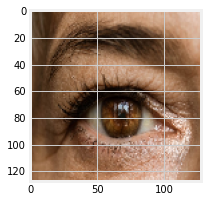

0.0


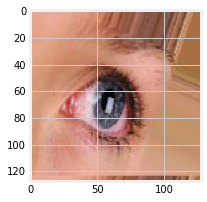

0.0


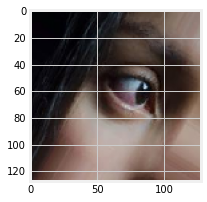

In [11]:
x_train, y_train = train_generator.__next__()


# checking/ verifying if the image and masks are coorelated
for i in range(0,3):
    image = x_train[i]
    plt.subplot(1,2,1)
    plt.imshow(image)
    print(y_train[i][0])
    plt.show()

In [12]:
# compling the model
model.compile(optimizer=keras.optimizers.Adam(0.5e-3), 
                loss=keras.losses.binary_crossentropy, metrics=['accuracy','Recall','Precision'])

cb = keras.callbacks.EarlyStopping(monitor="accuracy",
                                    min_delta=0.005,
                                    patience=30,
                                    verbose=1,
                                    mode="min",
                                    baseline=None,
                                    restore_best_weights=False)

In [13]:
history = model.fit(train_generator,
        batch_size = batchsize, 
        epochs = 50,
        verbose = 1, 
        validation_data = validation_generator)

Epoch 1/50
95/95 [==============================] - 16s 69ms/step - loss: 19.1857 - accuracy: 0.6491 - recall: 0.6512 - precision: 0.6451 - val_loss: 18.2287 - val_accuracy: 0.4970 - val_recall: 0.4970 - val_precision: 0.4970
Epoch 2/50
95/95 [==============================] - 5s 49ms/step - loss: 16.9663 - accuracy: 0.8556 - recall: 0.8567 - precision: 0.8495 - val_loss: 16.8286 - val_accuracy: 0.5562 - val_recall: 0.5680 - val_precision: 0.5614
Epoch 3/50
95/95 [==============================] - 5s 52ms/step - loss: 15.2738 - accuracy: 0.8493 - recall: 0.8483 - precision: 0.8403 - val_loss: 14.9402 - val_accuracy: 0.6923 - val_recall: 0.6982 - val_precision: 0.6782
Epoch 4/50
95/95 [==============================] - 5s 51ms/step - loss: 13.4797 - accuracy: 0.9009 - recall: 0.8957 - precision: 0.8995 - val_loss: 13.2983 - val_accuracy: 0.5562 - val_recall: 0.6036 - val_precision: 0.5455
Epoch 5/50
95/95 [==============================] - 5s 53ms/step - loss: 11.8894 - accuracy: 0.9136

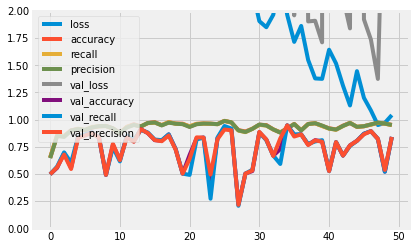

In [14]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,2) # set the y range to [0,1]
plt.show()

In [15]:
print('Model Evalution Score on Validation set')
print(model.evaluate(validation_generator))

Model Evalution Score on Validation set
17/17 [==============================] - 0s 20ms/step - loss: 15.6218 - accuracy: 0.8402 - recall: 0.8402 - precision: 0.8402
[15.621807098388672, 0.8402366638183594, 0.8402366638183594, 0.8402366638183594]


In [16]:
print('Model Evalution Score')
print(model.evaluate(test_generator))

Model Evalution Score
1/1 [==============================] - 0s 323ms/step - loss: 2.0140 - accuracy: 0.6364 - recall: 0.6364 - precision: 0.6364
[2.0139811038970947, 0.6363636255264282, 0.6363636255264282, 0.6363636255264282]


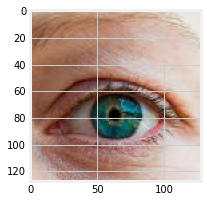

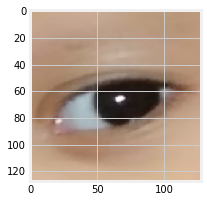

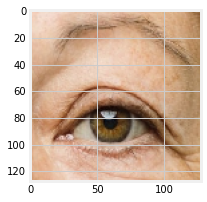

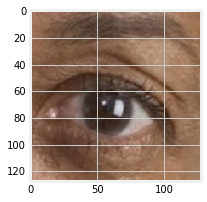

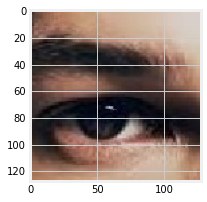

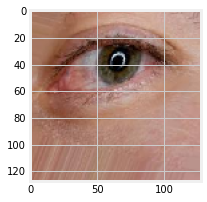

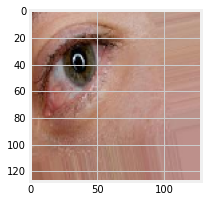

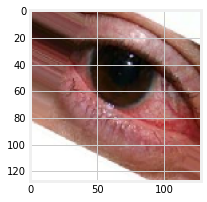

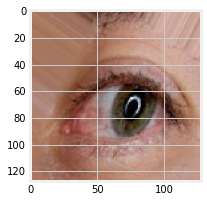

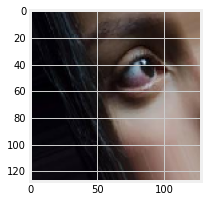

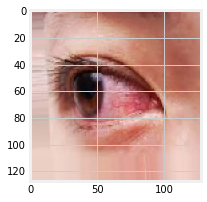

In [17]:
x_test, y_test = test_generator.__next__()

#print(y_test)
y_series_test = []
# checking/ verifying if the image and masks are coorelated
for i in range(0,11):
    image = x_test[i]
    plt.subplot(1,2,1)
    plt.imshow(image)
    y_series_test.append(int(y_test[i][1]))
    plt.show()

In [18]:
y_pred_test = model.predict(test_generator)
y_pred_test = y_pred_test.argmax(axis=-1)
cf_matrix = confusion_matrix(y_series_test, y_pred_test)
print(cf_matrix)

1/1 [==============================] - 1s 769ms/step
[[5 0]
 [4 2]]


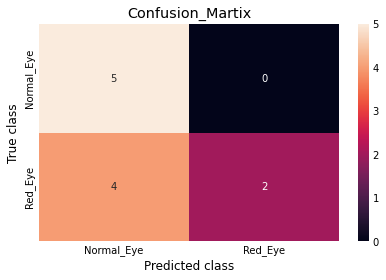

In [19]:
LABELS = ["Normal_Eye","Red_Eye"]
sns.heatmap(cf_matrix, annot=True, xticklabels=LABELS, yticklabels=LABELS,fmt = 'd')
plt.title("Confusion_Martix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()

In [20]:
pred_path = '../data/aug_red_eye/prediction_images'
number_of_images = '../data/aug_red_eye/prediction_images/prediction'
img_list_len = len(os.listdir(number_of_images))
batch_size = int(img_list_len)
pred_datagen = ImageDataGenerator(rescale=1./255)
pred_generator = pred_datagen.flow_from_directory(
    directory= pred_path,
    target_size=(WIDTH, HEIGHT),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
    seed=42
)

Found 9 images belonging to 1 classes.


1/1 [==============================] - 1s 756ms/step
Normal_Eye


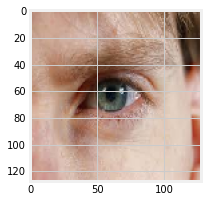

1/1 [==============================] - 0s 47ms/step
Normal_Eye


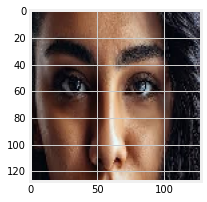

1/1 [==============================] - 0s 45ms/step
Red_Eye


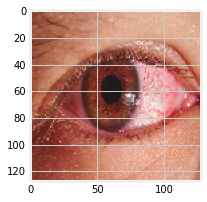

1/1 [==============================] - 0s 47ms/step
Normal_Eye


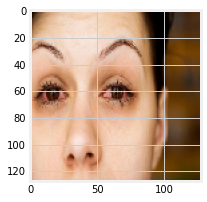

1/1 [==============================] - 0s 44ms/step
Red_Eye


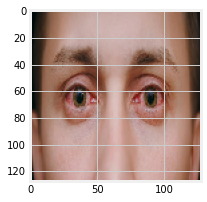

1/1 [==============================] - 0s 46ms/step
Normal_Eye


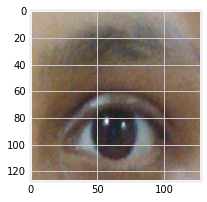

1/1 [==============================] - 0s 44ms/step
Normal_Eye


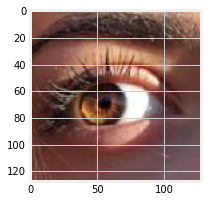

1/1 [==============================] - 0s 46ms/step
Red_Eye


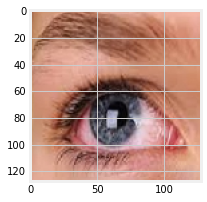

In [21]:
x_pred = pred_generator.__next__()


# checking/ verifying if the image and masks are coorelated
for i in range(0,batch_size-1):
    image = x_pred[i]
    plt.subplot(1,2,1)
    predict=model.predict(pred_generator)
    y_classes = predict.argmax(axis=-1)
    if y_classes[i] == 0:
        print('Normal_Eye')
    else:
        print('Red_Eye')
    #print(y_classes[i])
    plt.imshow(image)
    plt.show()
